# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [22]:
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [23]:
data = pd.read_csv('/datasets/users_behavior.csv')

In [24]:
display(data.head(20))

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [25]:
# выведем информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [26]:
data['is_ultra'].unique()

array([0, 1])

In [27]:
data['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Промежуточный вывод:
- пропуски отсутствуют,
- значения в столбце 'is_ultra' соответсвуют категориальному признаку и имеет значение только 0 или 1.
- видно, что распрееление столбце 'is_ultra' значений 0 и 1 не равноварное, нелбходимо это учесть при дальнешей расделении выборки. 

## Разбейте данные на выборки

Разделим выборку на обучающую, валидационную и тестовую в пропорции 3:1:1.

### Обучающая  выборка 

In [29]:
print('Исходная выборка:',data.shape)

Исходная выборка: (3214, 5)


In [30]:
# выделим обучающую выборку, 60% от общей выборки
data_train, data2 = train_test_split(data, test_size=0.4, random_state=12345, stratify=data[['is_ultra']])

In [31]:
print('Обучающая выборка:',data_train.shape)
print('Валидационная и Тестовая выборки:',data2.shape)

Обучающая выборка: (1928, 5)
Валидационная и Тестовая выборки: (1286, 5)


### Валидационая и тестовая выборки

In [32]:
# разделим оставшуюся часть 40% (features2 и target2 см. выше) на две равные выборки: валидационную и тестовую
data_valid, data_test = train_test_split(data2, test_size=0.5, random_state=12345, stratify=data2[['is_ultra']])

In [33]:
print('Валидационная выборка:',data_test.shape)
print('Тестовая выборка:',data_test.shape)

Валидационная выборка: (643, 5)
Тестовая выборка: (643, 5)


## Исследуйте модели

В задании нужно разработать модель рекомендации тарифа Смарт или Ультра. Выбор тарифа — это качественный целевой признак. 

### Извлечение признаков и целевого признака

In [34]:
# извлекем признаки и целевой признак

# обучающая выборка
features_train = data_train.drop(['is_ultra'], axis=1)
target_train = data_train['is_ultra']

# валидационная выборка
features_valid = data_valid.drop(['is_ultra'], axis=1)
target_valid = data_valid['is_ultra']

# тестовая выборка
features_test = data_test.drop(['is_ultra'], axis=1)
target_test = data_test['is_ultra']

### Модели

Тариф - качественный признак, значит, нужно решить задачу классификации. Будем исследовать следующие модели:
- Решающее дерево;
- Случайцный лес;
- Логистическая регрессия.

####  Модель - решающее дерево

Для получения наилучшей модели исользуем гирпепаратметр - глубина дерева.

In [35]:
model_tree = None
best_depth = 0
best_result_tree = 0
accuracy_result = []
tree_result = []
  
for depth in range(1,13):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    # посчитаем качество модели на валидационной выборке
    model.fit(features_train, target_train)
    # получим предсказание модели
    predictions_valid = model.predict(features_valid)
    # посчитаем качество модели на валидационной выборке
    result = accuracy_score(target_valid, predictions_valid)
    # сохраним результат для построения графика
    accuracy_result.append(result)
    tree_result.append(depth)
    if result > best_result_tree:
        # сохраним наилучшую модель
        model_tree = model
        #  сохраниим наилучшее значение метрики accuracy на валидационных данных
        best_result_tree = result 
        #  сохраниим наилучшее значение глубины
        best_depth = depth 

print("Accuracy наилучшей модели решающего дерева на валидационной выборке:", best_result_tree)
print("Глубина наилучшей модели решающего дерева на валидационной выборке:", best_depth)

Accuracy наилучшей модели решающего дерева на валидационной выборке: 0.80248833592535
Глубина наилучшей модели решающего дерева на валидационной выборке: 8


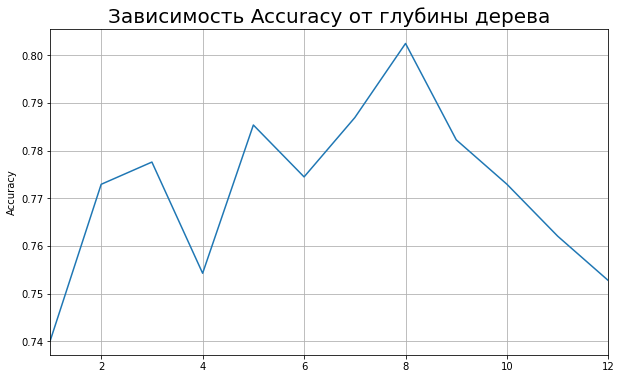

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.title('Зависимость Accuracy от глубины дерева',fontsize=20)
plt.ylabel('Accuracy')
plt.xlim([1, 12])
plt.grid(True)
plt.plot(tree_result, accuracy_result)
plt.show()

Промежуточный выод:
- Аccuracy наилучшей модели решающего дерева на валидационной выборке: 0.802. Соответствующая глубина равна 8.

####  Модель - случайный лес

Для выбора наилучшей модели будем использовать следующие гиперпараметры:
1. n_estimators - колчиество деревьев
2. max_depth - глубина деревьев
3. bootstrap - использование для построения деревьев подвыборки с возвращением.

In [37]:
%%time

model_forest = None
tree_numbers = 0
best_result_forest = 0
for est in range(1, 50):
    for depth in range(1,12):
    # обучим модель с заданным количеством деревьев
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, bootstrap=True) 
    # обучаем модель на тренировочной выборке
        model.fit(features_train, target_train) 
    # получим предсказание модели
        predictions_valid = model.predict(features_valid)
    # посчитаем качество модели на валидационной выборке
        result = accuracy_score(target_valid, predictions_valid) 
        if result > best_result_forest:
        # сохраним наилучшую модель
            model_forest = model 
        # сохраним наилучшее значение метрики accuracy на валидационных данных 
            best_result_forest = result 
        # сохраним количество диревьев для наилучшей модели на валидационных данных
            tree_numbers = est
        # сохраним глубину для наилучшей модели на валидационных данных   
            best_depth = depth

print("Accuracy наилучшей модели на валидационной выборке:", best_result_forest)
print("Количество деревьев наилучшей модели на валидационной выборке:", tree_numbers)
print("Максимальная глубина деревьев на валидационной выборке:", best_depth)

Accuracy наилучшей модели на валидационной выборке: 0.8227060653188181
Количество деревьев наилучшей модели на валидационной выборке: 39
Максимальная глубина деревьев на валидационной выборке: 9
CPU times: user 35.1 s, sys: 172 ms, total: 35.3 s
Wall time: 1min 10s


Промежуточный вывод:
- Аccuracy наилучшей модели случайного леса на валидационной выборке: 0.823.
- Соответствующая глубина равна 9.
- Количество деревьев 39.

####  Модель - логистическая регрессия

In [38]:
# обучим модель с заданным количеством деревьев 
model_log_reg = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
# обучим модель на тренировочной выборке
model_log_reg.fit(features_train, target_train) 
# получим предсказание модели
predictions_log_reg_valid = model_log_reg.predict(features_valid)
# посчитаем качество модели на валидационной выборке
result_log_reg = accuracy_score(target_valid, predictions_log_reg_valid) 

print("Accuracy наилучшей модели на валидационной выборке:", result_log_reg)

Accuracy наилучшей модели на валидационной выборке: 0.7387247278382582


Вывод:
1. Наилучшей результат на валидационной выборке показала модель случайного леса со следующимим гиперепараметрами:
- количество деревьев 23;
- глубина деревьев 7;
- параметр использование для построения деревьев подвыборки с возвращением bootstrap=False.
2. Модель логистической реграссии показала наихудший результат.


## Проверьте модель на тестовой выборке

Поскольку модель случайного леса показала наилучшие результат, выбираем ее для проверки на тестовых данных.

### Проверка модели случаного леса на тестовой выборке

In [39]:
# получим предсказание модели случацного леса на тестовой выборке
predictions_forest_test = model_forest.predict(features_test)
# посчитаем качество модели случацного леса на тестовой выборке
result_forest = accuracy_score(target_test, predictions_forest_test)
# результат
print("Accuracy модели случайного леса на тестовой выборке:", result_forest)

Accuracy модели случайного леса на тестовой выборке: 0.8118195956454122


## Общий вывод:
В ходе работы были выполнены следующие задания:
1. Загружены данные о поведении клиентов, которые уже перешли на исследуемые тарифы.
2. В данных видно, что один из тарифов выбирают чаще, это было учтено при далнешем разбиении.
3. Данные разбиты на 3 выборки (тренировочная, валидаионная и тестовая) в пропорциях 3:1:1 с учетом стратификации данных.
4. Были рассмотрены 3 модели: 
- Случайный лес.  Наилучшей результат accurcy на валидационной выборке составил 0,823 со следующимим гиперепараметрами: количество деревьев 39, глубина деревьев 9;
- Логистическое дерево.  Результаты accurcy на валидационной выборке нескоклько хуже, accuracy = 0,785;
- Логистическая реграссия. Наихудший результат accurcy на валидационной выборке с показателем accurcy = 0,711.
5. В качестве наилцчшей модели была выбрана модель случайного леса.
6. Для проверки работоспособности модели  случайного леса на тестовой выборке: accuracy=0.802.
